# KLUE-TC(YNAT) dataset (2800개)

- Labeling Error - 1000개는 라벨을 임의로 바꿈
→ 올바른 라벨로 재맵핑 필요
- Random Noise - 1600개는 text에 노이즈를 추가. 임의의 char 중 20~80%를 랜덤으로 다른 아스키코드로 대체
→ 높은 노이즈를 가지는 text는 제외, 낮은 샘플은 복구가 필요
→ 사람이 개별 판단하지 말 것. 자동 detection이 가능하게 하여 수정하거나, 삭제하거나 진행
- Normal Dataset - 200개

In [4]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,ID,text,target
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4
1,ynat-v1_train_00001,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,3
2,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5
4,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6


In [5]:
# 화살표가 포함된 행을 필터링
arrows = ['→', '←', '↑', '↓', '↔']
mask = df['text'].str.contains('|'.join(arrows))  # 화살표 기호가 포함된 행 찾기
df_with_arrows = df[mask]

# 결과 출력
df_with_arrows.head()

,ID,text,target
134,ynat-v1_train_00134,코오롱플라스틱 1분기 연결 영업익 58억원…138%↑,6
154,ynat-v1_train_00154,[반기 전}FjQQ 74Q여z…L년보~ 3.1%↓,5
156,ynat-v1_train_00156,GS칼텍스 IBK기업은행과 세터 이나연↔이고은 트레이드,5
169,ynat-v1_train_00169,e5 >사채 @행V0.9조원…Or대비O55z↑,5
186,ynat-v1_train_00186,KB증권 농심 4분기 라면 부문 실적개선…목표주가↑,6


In [6]:
# 공백으로 대체
df['text'] = df['text'].str.replace('…', ' ', regex=False)
df['text'] = df['text'].str.replace('...', ' ', regex=False)
df['text'] = df['text'].str.replace('·', ' ', regex=False)
# 화살표 기호 의미 대체
df['text'] = df['text'].str.replace('→', '에서', regex=False)
df['text'] = df['text'].str.replace('↑', '상승', regex=False)
df['text'] = df['text'].str.replace('↓', '하락', regex=False)
df['text'] = df['text'].str.replace('↔', ' ', regex=False)

In [7]:
# 정규 표현식 정의: 소수점 뒤에 숫자가 있으며, 그 뒤에 '%'가 있는 패턴
pattern = r'\d+\.\d+%'

# '.숫자%' 구성으로 이루어진 데이터 필터링
df_filtered = df[df['text'].str.contains(pattern, regex=True)]

# 결과 출력
df_filtered.head()

,ID,text,target
133,ynat-v1_train_00133,?씨D m년 h업8 16<K* h4.8%3,5
154,ynat-v1_train_00154,[반기 전}FjQQ 74Q여z L년보~ 3.1%하락,5
473,ynat-v1_train_00473,네이버 검색 광고 전체 광고 매출의 82.4% 차지,0
745,ynat-v1_train_00745,서울 표준주택 공시가 17.75%상승 15억 초과 고가주택 정밀 조준종합2보,4
929,ynat-v1_train_00929,(난해 OV은행 신용대w금리 3.2%p하락(#자 2천= 감소,5


In [8]:
# 특수 기호의 패턴 정의
# 이 예시에서는 영숫자 이외의 모든 기호를 특수 기호로 간주합니다.
# special_char_pattern = r'[^가-힣A-Z\u4E00-\u9FFF\s0-9]'
# .숫자% 형식을 제외하고, ㎜도 특수 기호에서 제외
special_char_pattern = r'(?<!\d)\.(?!\d)|(?<!\d)%|[^가-힣A-Z\u4E00-\u9FFF\s0-9\.%㎜㎡]'

# 각 text에 포함된 특수 기호의 개수를 세는 함수 정의
def count_special_characters(text):
    return len(re.findall(special_char_pattern, text))

# 데이터프레임에 새로운 열 추가
df['special_char_count'] = df['text'].apply(count_special_characters)
df['special_char_ratio'] = df['special_char_count'] / df['text'].str.len()

df_sorted = df.sort_values(by='special_char_ratio', ascending=False)

# 결과 출력
df_sorted.head()

,ID,text,target,special_char_count,special_char_ratio
624,ynat-v1_train_00624,"사건!>실""를 b$#라 #극)]체O.;월f:?",0,14,0.560000
2413,ynat-v1_train_02413,"전W;참c 이nd 유j]""m객ie((우려` ?<. 개조",6,16,0.533333
2275,ynat-v1_train_02275,더*} ]i대+ 김현권!v원a}_대8*vdL줄!알았d,2,15,0.500000
2765,ynat-v1_train_02765,"$G ;!p 서울 |곳 나vo객 =적""bs 귀s,d거)",3,15,0.500000
1203,ynat-v1_train_01203,nO통령z\후 p싱턴으로 ^R!與지p부 @re-#{{\,2,15,0.500000


In [9]:
# 출력 옵션을 설정하여 모든 행이 표시되도록 함
pd.set_option('display.max_rows', None)

# special_char_ratio가 0.2 이상인 데이터 필터링
noise_df = df_sorted[df_sorted['special_char_ratio'] >= 0.042]
print(len(noise_df))

# 결과 출력
noise_df.head()

# 출력 옵션을 원래대로 복구
pd.reset_option('display.max_rows')

1595


In [11]:
# df_high_ratio의 인덱스를 이용하여 제외할 행을 찾음
clean_df = df[~df.index.isin(noise_df.index)]

print(len(clean_df))
clean_df.head()

1205


,ID,text,target,special_char_count,special_char_ratio
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,5,0,0.0
5,ynat-v1_train_00005,美성인 6명 중 1명꼴 배우자 연인 빚 떠안은 적 있다,0,0,0.0
7,ynat-v1_train_00007,아가메즈 33득점 우리카드 KB손해보험 완파 3위 굳,4,0,0.0
8,ynat-v1_train_00008,朴대통령 얼마나 많이 놀라셨어요 경주 지진현장 방문종합,6,0,0.0
9,ynat-v1_train_00009,듀얼심 아이폰 하반기 출시설 솔솔 알뜰폰 기대감,4,0,0.0


# 클러스터링 기반 라벨링 확인

In [12]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text'])
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8019 stored elements and shape (1205, 5887)>

In [13]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

In [14]:
kmeans = KMeans(n_clusters=7, random_state=42)
clean_df['cluster'] = kmeans.fit_predict(X_pca)

/tmp/ipykernel_47034/534411617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['cluster'] = kmeans.fit_predict(X_pca)


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45684 (\N{HANGUL SYLLABLE NYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/c

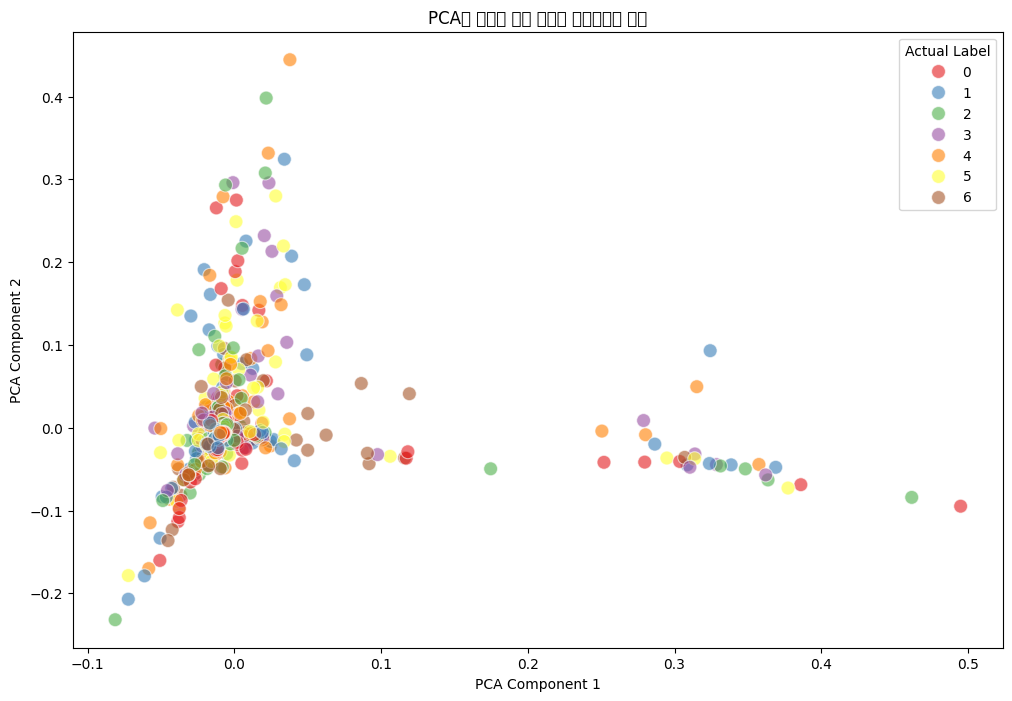

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clean_df['target'], palette='Set1', s=100, alpha=0.6, edgecolor='w')
plt.title('PCA로 축소된 뉴스 제목의 클러스터링 결과')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Actual Label')
plt.show()

In [16]:
clean_df['label_match'] = clean_df['target'] == clean_df['cluster']
mismatched_labels = clean_df[clean_df['label_match'] == False]
print(f"잘못 라벨링된 데이터 수: {len(mismatched_labels)}")
display(mismatched_labels[['text', 'target', 'cluster']])


잘못 라벨링된 데이터 수: 1020


/tmp/ipykernel_47034/954704717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['label_match'] = clean_df['target'] == clean_df['cluster']


,text,target,cluster
3,갤노트8 주말 27만대 개통 시장은 불법 보조금 얼룩,5,3
7,아가메즈 33득점 우리카드 KB손해보험 완파 3위 굳,4,0
8,朴대통령 얼마나 많이 놀라셨어요 경주 지진현장 방문종합,6,0
9,듀얼심 아이폰 하반기 출시설 솔솔 알뜰폰 기대감,4,0
11,NH투자 1월 옵션 만기일 매도 우세,1,0
...,...,...,...
2793,경찰 5월초 유커와 日관광객위해 바가지 요금 집중 단속,1,0
2794,문 대통령 김기식 금감원장 사표 수리키로종합,2,4
2795,트럼프 폭스뉴스 앵커들 충성도 점수매겨 10점만점에 12점도,6,0
2798,인터뷰 류현진 친구에게 안타 맞는 것 싫어해 승부는 냉정,1,0
